In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import matplotlib.colors
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from scipy.interpolate import griddata
from shapely.geometry import Point

The objective of this code is to plot the skill at reproducing of three turbine approaches:

- The power curve best representing national ramps

- The single power curve with the best overall performance for farm ramps

- The corresponding turbine model for each farm, but with the smoothing that minimises the RMSE

### Load the skill scores for the three approached for each farm

In [2]:
rmse = pd.read_csv('../data/rmse_compare_farms.csv', index_col=0)
mbe = pd.read_csv('../data/mbe_compare_farms.csv', index_col=0)
cc = pd.read_csv('../data/cc_compare_farms.csv', index_col=0)
area_overlap = pd.read_csv('../data/area_overlap_compare_farms.csv', index_col=0)

In [3]:
dataframes = [rmse, mbe, cc]
titles = ['RMSE', 'MBE', 'CC']
colors = ['blue', 'orangered', 'green']  # Colors for each column
facecolors = ['lavender', 'mistyrose', 'honeydew']  # Colors for each column

### Load the spatial distribution data

In [4]:
ramp_1y_return_national = xr.open_dataarray('../data/ramp_1y_return_national.nc')
ramp_1y_return_farms = xr.open_dataarray('../data/ramp_1y_return_farms.nc')

Load the spatial data

In [ ]:
boundaries = gpd.read_file('../data/NUTS_RG_01M_2021_4326/NUTS_RG_01M_2021_4326.shp', crs="epsg:4326")
boundaries_ni = boundaries[boundaries['NUTS_ID']=='UKN0']
boundaries = boundaries[boundaries['NUTS_ID']=='IE']

### Plot the skill scores into a box plot

In [ ]:
da_lsm = xr.open_dataarray('../data/ERA5_land_sea_mask.nc')

In [8]:
ramp_1y_return_interp = griddata((ramp_1y_return_national['lon'].values,ramp_1y_return_national['lat'].values),ramp_1y_return_national.values, tuple(np.meshgrid(da_lsm['longitude'],da_lsm['latitude'])), method='linear')

In [9]:
da_ramp_1y_return_interp = xr.DataArray(ramp_1y_return_interp, dims=da_lsm.dims, coords=da_lsm.coords)

We want to NaN anything that is not within the limits of Ireland.

In [12]:
def is_point_inside_geometry(lon, lat, gdf):
    """
    Checks if a given (lon, lat) point falls inside any geometry of a GeoDataFrame.
    
    Parameters:
        lon (float): Longitude of the point
        lat (float): Latitude of the point
        gdf (GeoDataFrame): GeoPandas GeoDataFrame containing the geometries
    
    Returns:
        bool: True if the point is inside any geometry, False otherwise
    """
    point = Point(lon, lat)  # Create a Shapely Point object
    return gdf.contains(point).any()  # Check if the point is inside any geometry

for ilon, lon in enumerate(da_ramp_1y_return_interp['longitude']):
    for ilat, lat in enumerate(da_ramp_1y_return_interp['latitude']):
        inside = is_point_inside_geometry(lon, lat, boundaries_ni)
        if inside:
            da_ramp_1y_return_interp[ilat,ilon] = np.nan


In [13]:
bounds = np.arange(0.74, 0.86, 0.01)
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

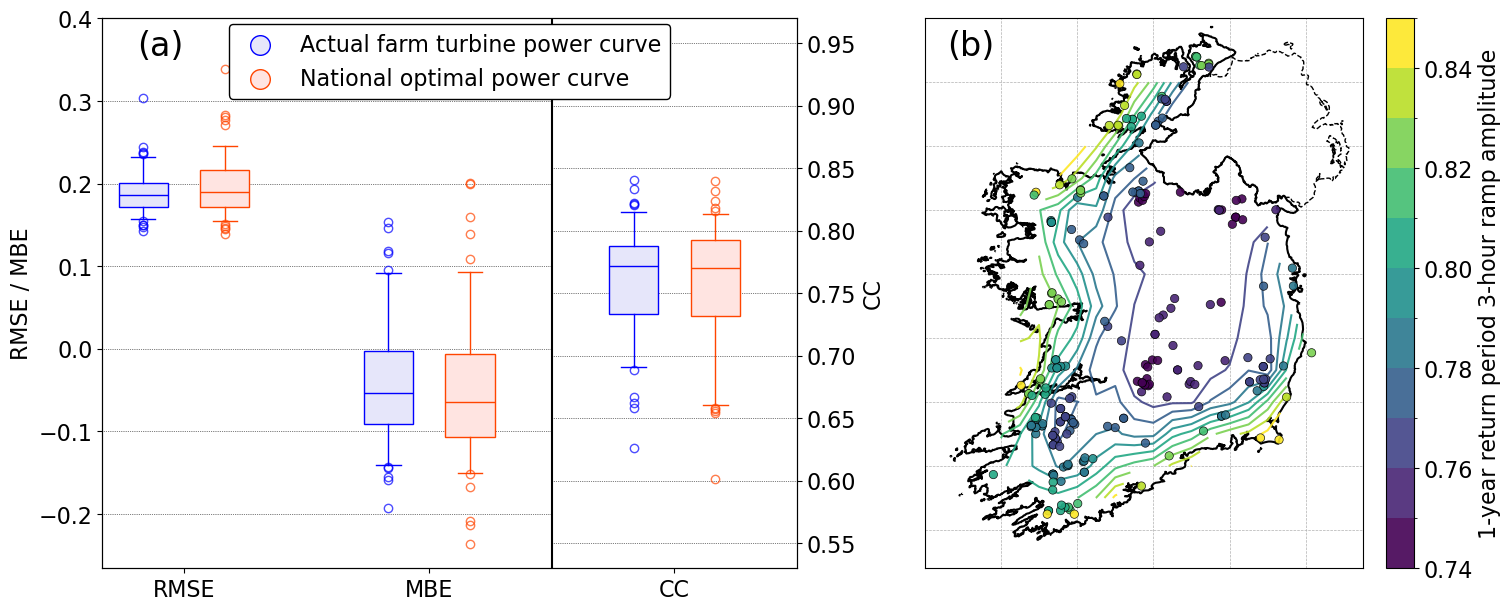

In [16]:
# Define the figure and the grid layout
fig, [ax1, ax_mid] = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True, gridspec_kw={'width_ratios': [1.5, 1]})

# ==========================
# Left Panel (Boxplot)
# ==========================
ax2 = ax1.twinx()

# Set grid for left plot
ax1.hlines(np.arange(-0.2, 0.35, 0.1), -0.5, 5, ls=':', colors='k', lw=0.5, zorder=1)
ax2.hlines(np.arange(0.55, 1., 0.05), 5, 14.5, ls=':', colors='k', lw=0.5, zorder=1).set_zorder(1)

# Box plot positions
positions = []
current_position = 0
new_tick_labels = []

# Loop through dataframes and plot (excluding "Farm-optimal" bars)
for i, df in enumerate(dataframes):
    for j, column in enumerate(df.columns[:-1]):  # Exclude the last column (Farm-optimal)
        if i < 2:  # RMSE and MBE (left y-axis)
            axis = ax1
        else:  # CC and area_overlap (right y-axis)
            axis = ax2

        # Plot boxplot
        box = axis.boxplot(
            df[column],
            positions=[current_position],
            widths=0.6,
            whis=(5,95),
            patch_artist=True,
            boxprops=dict(facecolor=facecolors[j], edgecolor=colors[j]),
            medianprops=dict(color=colors[j]),
            whiskerprops=dict(color=colors[j]),
            capprops=dict(color=colors[j]),
            flierprops=dict(marker='o', markeredgecolor=colors[j], alpha=0.7)
        )
        new_tick_labels.append(column)
        current_position += 1

    current_position += 1
    positions.append(current_position - 1)
    new_tick_labels.append("")

# Add separating line between MBE and CC
ax1.axvline(positions[1], color='black', linestyle='-', linewidth=1.5)

# Axis labels and ticks
ax1.set_ylabel('RMSE / MBE', fontsize=16)
ax2.set_ylabel('CC', fontsize=16)
ax2.set_yticks(np.arange(0.55, 1., 0.05))
ax1.set_xticks([0.5, 3.5, 6.5])  # Adjusted for removed bar
ax1.set_xticklabels(['RMSE', 'MBE', 'CC'], fontsize=16)
ax1.tick_params(labelsize=16, axis='y')
ax2.tick_params(labelsize=16, axis='y')
ax1.set_xlim(-0.5, 8)
ax1.set_ylim(top=0.4)

# Legend (excluding "Farm-optimal")
handles = [plt.scatter([], [], edgecolor=color, color=facecolors[ii], marker='o', s=200) for ii, color in enumerate(colors[:-1])]
labels = ['Actual farm turbine power curve', 'National optimal power curve']
ax2.legend(handles, labels, loc='upper center', fontsize=16, framealpha=1., facecolor='white', edgecolor='k', bbox_to_anchor=(0.5, 1.01)).set_zorder(6)

# ==========================
# Middle Panel (National Ramps)
# ==========================
# Plot boundaries
boundaries_ni.boundary.plot(ax=ax_mid, edgecolor='black', linestyle='--', linewidth=1)
boundaries.boundary.plot(ax=ax_mid, edgecolor='black', linestyle='-', linewidth=1.5)

ax_mid.contour(
    da_ramp_1y_return_interp['longitude'],
    da_ramp_1y_return_interp['latitude'],
    da_ramp_1y_return_interp,
    cmap='viridis',
    alpha=0.9,
    norm=norm,
    levels = bounds[2:-1],
    zorder=2
)

# Scatter plot for national ramps
sc_mid = ax_mid.scatter(
    ramp_1y_return_national['lon'],
    ramp_1y_return_national['lat'],
    c = ramp_1y_return_national,
    cmap='viridis',
    alpha=0.9,
    norm=norm,
    linewidths=0.5,
    edgecolors='k',
    zorder=3
)



# sc_mid = da_ramp_1y_return_interp.plot(ax=ax_mid, alpha=0.9, add_colorbar=False, norm=norm)
# ax_mid.scatter(ramp_1y_return_national['lon'], ramp_1y_return_national['lat'], s=8, c='white', edgecolors='k', linewidths=0.5)

ax_mid.grid(visible=True, linestyle='--', linewidth=0.5)
ax_mid.set_xticklabels([])
ax_mid.set_yticklabels([])
ax_mid.set_xlabel('')
ax_mid.set_ylabel('')
ax_mid.set_ylim(bottom=51.2)

# ==========================
# Shared Colorbar
# ==========================
cbar = plt.colorbar(sc_mid)  # Now tied to the only remaining map
cbar.set_label('1-year return period 3-hour ramp amplitude', fontsize=16)
cbar.ax.tick_params(labelsize=16)


ax_mid.tick_params(axis='x', which='both', bottom=False, top=False)
ax_mid.tick_params(axis='y', which='both', left=False, right=False)

ax1.text(0.05, 0.98, '(a)', ha='left', va='top', fontsize=24, transform=ax1.transAxes)
ax_mid.text(0.05, 0.98, '(b)', ha='left', va='top', fontsize=24, transform=ax_mid.transAxes)


fig.savefig('../figures/ramps_farms_analysis_contour.png', bbox_inches='tight', dpi=300)
